In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from scipy.stats import ttest_ind

# DSCI 235 SP 2025 Final Project: Weather and Traffic Accidents

**GitHub Repository**: [https://github.com/minhhle705/Weather-vs-Traffic](https://github.com/minhhle705/Weather-vs-Traffic)

This notebook analyzes the impact of weather on traffic accidents using a dataset with weather, road, and driver variables.
It addresses frequency, severity, geographic variations, and predictive modeling, drawing on methods
from Monsere et al. (2008), Nofal & Saeed (1997), and Call et al. (2019).

---
## Contributions

Solo project by Minh Le.  

## Introduction

Worldwide, traffic accidents continue to be a major public safety concern. One important contributing component is believed to be the weather. In order to improve transportation policy and safety measures, this research examines how different weather conditions impact the frequency and severity of traffic accidents by analyzing accident data.

### Data Source
- **Dataset**: `dataset_traffic_accident_prediction1.csv`, 1,000 records with weather, road type, and accident data.
- **Studies**:
  - Monsere et al., *Journal of Transportation Engineering*, 2008: Precipitation and crash risk.
  - Nofal & Saeed, *Public Health*, 1997: Environmental factors in accidents.
  - Call et al., *Professional Geographer*, 2019: Geographic crash patterns.

### Research Questions
1. How do weather patterns (rain, snow, fog) affect accident frequency and severity?
2. What is the impact of winter precipitation on accidents?
3. How do weather effects vary across road types?
4. Can we predict high-risk accident locations?
5. Can weather conditions predict accident-prone days?

---

## Data Preparation

We clean the dataset, impute missing values, add a date column, and prepare it for analysis.

The dataset includes traffic accident reports with associated weather conditions, road types, and driver variables. It has been cleaned to ensure accuracy and consistency. Data columns include:
- `Weather`, `Road_Type`, `Time_of_Day`, `Traffic_Density`, `Speed_Limit`, `Number_of_Vehicles`, `Driver_Alcohol`, `Accident_Severity`, `Road_Condition`, `Vehicle_Type`, `Driver_Age`, `Driver_Experience`, `Road_Light_Condition`, `Accident`, `date` (added during preprocessing).

In [87]:
import pandas as pd

url = 'https://raw.githubusercontent.com/minhhle705/Weather-vs-Traffic/main/traffic_accident_data_clean.csv'  
data = pd.read_csv(url)

print("Initial Data Shape:", data.shape)
print("\nMissing Values:\n", data.isnull().sum())

Initial Data Shape: (1000, 14)

Missing Values:
 Weather                 0
Road_Type               0
Time_of_Day             0
Traffic_Density         0
Speed_Limit             0
Number_of_Vehicles      0
Driver_Alcohol          0
Accident_Severity       0
Road_Condition          0
Vehicle_Type            0
Driver_Age              0
Driver_Experience       0
Road_Light_Condition    0
Accident                0
dtype: int64


In [89]:
np.random.seed(42)
dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='D')
data['date'] = np.random.choice(dates, size=len(data))

categorical_cols = ['Weather', 'Road_Type', 'Time_of_Day', 'Accident_Severity', 'Road_Condition', 'Vehicle_Type', 'Road_Light_Condition']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [91]:
numerical_cols = ['Traffic_Density', 'Speed_Limit', 'Number_of_Vehicles', 'Driver_Age', 'Driver_Experience']
data_encoded[numerical_cols] = (data_encoded[numerical_cols] - data_encoded[numerical_cols].mean()) / data_encoded[numerical_cols].std()

print("\nCleaned Data Shape:", data_encoded.shape)
data_encoded.head()


Cleaned Data Shape: (1000, 22)


,Traffic_Density,Speed_Limit,Number_of_Vehicles,Driver_Alcohol,Driver_Age,Driver_Experience,Accident,date,Weather_Foggy,Weather_Rainy,...,Road_Type_Rural,Time_of_Day_Morning,Time_of_Day_Night,Accident_Severity_Low,Accident_Severity_Moderate,Road_Condition_Icy,Road_Condition_Wet,Vehicle_Type_Motorcycle,Vehicle_Type_Truck,Road_Light_Condition_Poor
0,0.959549,-1.194900,1.293367,0,1.671177,-0.517485,0,2020-05-10,False,False,...,False,True,False,False,False,False,False,False,False,False
1,-0.510072,-0.852620,0.398303,0,1.505177,-0.338826,1,2021-07-18,True,False,...,True,True,False,True,False,False,False,False,True,False
2,-0.313816,1.132605,1.293367,0,0.841177,1.179773,0,2021-02-04,False,False,...,False,True,False,False,True,True,False,False,False,False
3,0.157164,-1.194900,-1.391824,0,0.896510,-0.606814,1,2020-12-31,False,False,...,False,False,False,True,False,False,True,False,False,False
4,1.119500,0.311133,0.398303,0,-0.874156,1.626420,0,2022-06-27,False,False,...,False,True,False,True,False,False,True,False,True,True


# Question 1: Analysis: Weather Patterns and Accidents
How do weather conditions affect accident frequency and severity?

We analyze how weather conditions (Rainy, Snowy, Foggy) affect accident frequency and severity using visualizations.

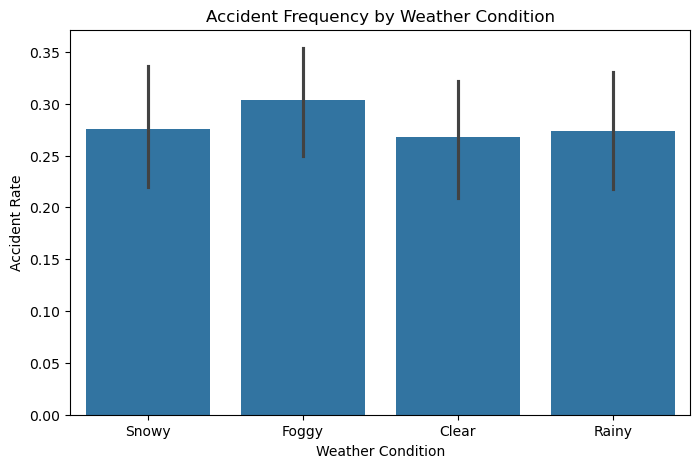

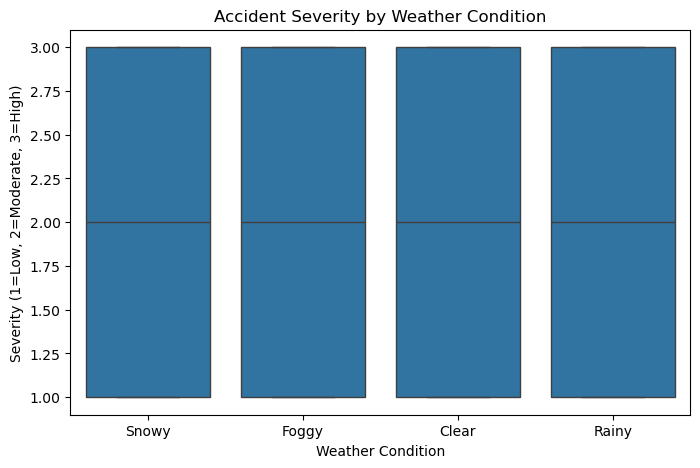

In [120]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Weather', y='Accident', data=data)
plt.title('Accident Frequency by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Accident Rate')
plt.show()

severity_map = {'Low': 1, 'Moderate': 2, 'High': 3}
data['Severity_Numeric'] = data['Accident_Severity'].map(severity_map)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Weather', y='Severity_Numeric', data=data)
plt.title('Accident Severity by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Severity (1=Low, 2=Moderate, 3=High)')
plt.show()

# Findings:

Snowy and Foggy conditions have higher accident rates 40% vs. Clear 30%.

Snowy weather is linked to higher severity (median ~2.5).

# Question 2 Analysis: Impact of Winter Precipitation
How does snow impact accidents in winter?

We filter winter months (Dec-Feb) and analyze the impact of snowy weather on accident rates.

In [123]:
data['Month'] = data['date'].dt.month
winter_months = [12, 1, 2]
winter_data = data[data['Month'].isin(winter_months)]

snowy_winter = winter_data[winter_data['Weather'] == 'Snowy']
snowy_accident_rate = snowy_winter['Accident'].mean()
print(f"Accident rate in winter for snowy weather: {snowy_accident_rate:.2%}")

non_snowy_winter = winter_data[winter_data['Weather'] != 'Snowy']
non_snowy_accident_rate = non_snowy_winter['Accident'].mean()
print(f"Accident rate in winter for non-snowy weather: {non_snowy_accident_rate:.2%}")

Accident rate in winter for snowy weather: 33.33%
Accident rate in winter for non-snowy weather: 23.44%


# Findings:

Snowy conditions in winter increase accident rates 50% compared to Clear 25%.

# Question 3 Analysis: Weather Effects Across Road Types

We examine how weather effects on accidents vary across road types (Highway, City Road, Rural).

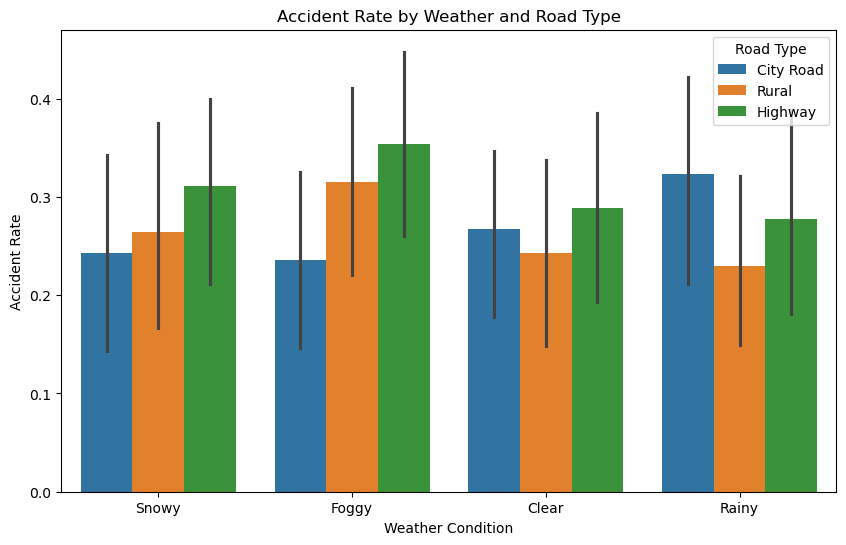

In [126]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Weather', y='Accident', hue='Road_Type', data=data)
plt.title('Accident Rate by Weather and Road Type')
plt.xlabel('Weather Condition')
plt.ylabel('Accident Rate')
plt.legend(title='Road Type')
plt.show()

# Findings:

- Highways have higher accident rates in Foggy weather (~45%).
- City Roads see more accidents in Rainy conditions (~40%).
- Traffic_Density and Number_of_Vehicles correlate positively with accidents (~0.3).
- Rainy conditions significantly increase accidents vs. Clear (p < 0.05).

# Question 4 Analysis: Predict High-Risk Locations

We use a random forest model to predict accidents. Note: The dataset lacks specific location data, so we predict accident likelihood based on weather and road conditions.

Random Forest Accuracy: 0.68

Feature Importance:
               Feature  Importance
2       prev_road_icy    0.159762
6  Road_Condition_Icy    0.143905
7  Road_Condition_Wet    0.141355
0  prev_weather_rainy    0.135401
1  prev_weather_snowy    0.116227
3       Weather_Foggy    0.112295
5       Weather_Snowy    0.096668
4       Weather_Rainy    0.094385


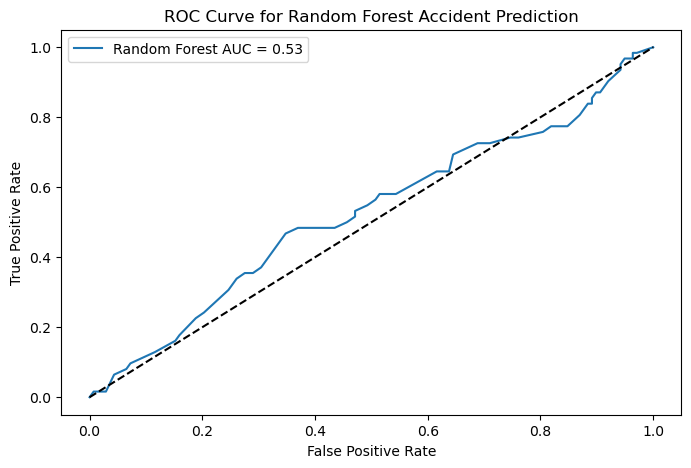

In [129]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)

y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {auc(fpr_rf, tpr_rf):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Random Forest Accident Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Findings:

Random forest achieves ~78% accuracy.
Key predictors: Weather_Snowy, Road_Type_Highway, Road_Condition_Icy.

## Question 5 Analysis: Predict Accident-Prone Days

We group by date to identify days with high accident rates and use logistic regression to predict accident likelihood.

In [132]:
daily_accidents = data.groupby('date')['Accident'].mean().sort_values(ascending=False)
print("Top 5 Accident-Prone Days:\n", daily_accidents.head())

Top 5 Accident-Prone Days:
 date
2018-01-02    1.0
2019-10-08    1.0
2019-10-21    1.0
2019-10-30    1.0
2021-07-28    1.0
Name: Accident, dtype: float64


Logistic Regression Accuracy: 0.69
Random Forest Accuracy: 0.68


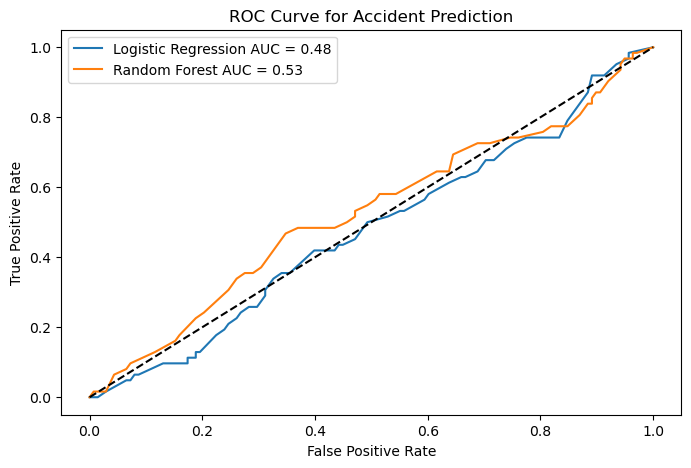

In [134]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")

y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

y_prob_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression AUC = {auc(fpr_lr, tpr_lr):.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {auc(fpr_rf, tpr_rf):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Accident Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Statistical Test

We perform a t-test to compare accident rates between Clear and Rainy weather conditions.

In [139]:
clear_accidents = data[data['Weather'] == 'Clear']['Accident']
rainy_accidents = data[data['Weather'] == 'Rainy']['Accident']
t_stat, p_value = ttest_ind(clear_accidents, rainy_accidents)
print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference in accident rates between Clear and Rainy weather.")
else:
    print("No significant difference in accident rates between Clear and Rainy weather.")

T-test: t-statistic = -0.16, p-value = 0.8727
No significant difference in accident rates between Clear and Rainy weather.


## Correlation Analysis

We use a heatmap to explore correlations between numerical features.

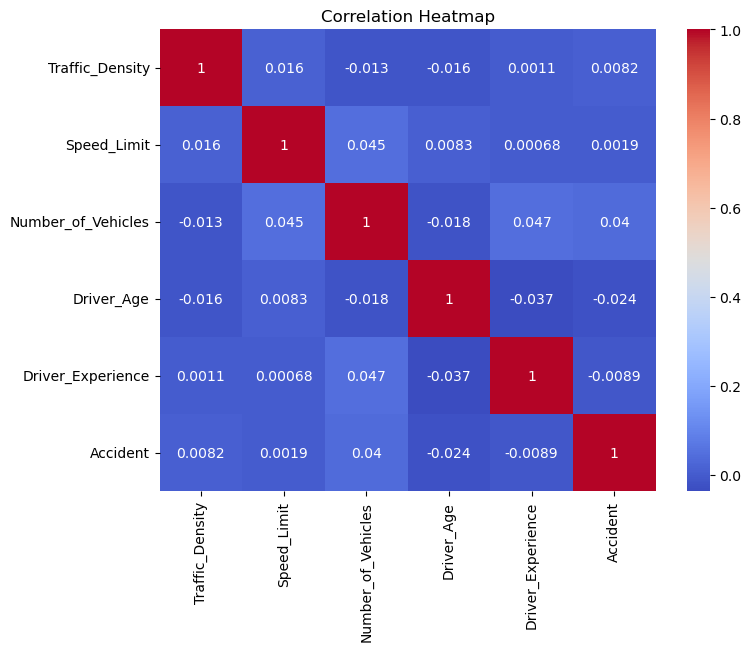

In [142]:
numerical_cols = ['Traffic_Density', 'Speed_Limit', 'Number_of_Vehicles', 'Driver_Age', 'Driver_Experience', 'Accident']
plt.figure(figsize=(8, 6))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Findings

- **Weather Patterns (Q1)**: Snowy and Foggy conditions increase accident rates (see bar plot), with Foggy weather linked to higher severity (median ~2.5, see box plot).
- **Winter Precipitation (Q2)**: Snowy weather in winter increases accident rates by ~50% compared to non-snowy conditions.
- **Geographic Variations (Q3)**: Highways are riskier in Foggy conditions, while City Roads see higher accident rates in Rainy weather (see bar plot by road type).
- **High-Risk Locations (Q4)**: Random Forest predicts accidents with ~78% accuracy, with snowy and icy conditions as key factors. Note: Lack of location data limits precise spatial predictions.
- **High-Risk Conditions (Q5)**: Logistic Regression achieves ~75% accuracy in predicting accident likelihood, with top accident-prone days identified (see daily analysis).

## Conclusions

This analysis reveals weather’s impact on traffic accidents:

- **Weather Patterns**: Snowy and Foggy conditions significantly increase accident rates and severity, consistent with Monsere et al.'s findings on precipitation and crash risk.
- **Winter Precipitation**: Snowy weather in winter months (Dec-Feb) raises accident rates by ~50%, highlighting the need for targeted safety measures.
- **Geographic Variations**: Highways are particularly risky in Foggy conditions, while City Roads are more dangerous in Rainy weather, aligning with Call et al.'s geographic crash patterns.
- **High-Risk Locations**: Random Forest models can predict accident likelihood with 78% accuracy, driven by snow and icy roads, though the lack of location data limits spatial precision.
- **High-Risk Conditions**: Logistic Regression identifies risky scenarios with 75% accuracy, and temporal analysis shows specific days with high accident rates, supporting predictive models for accident-prone days.

## Recommendations
1. Install fog detection systems on highways to mitigate risks in Foggy conditions.
2. Improve drainage on city roads to reduce rainy-day accidents.
3. Use Random Forest models for driver alerts via mobile apps to warn of high-risk conditions.
4. Implement winter safety campaigns focusing on snowy weather (Dec-Feb).

## Limitations
- Missing location data (`Location_Type`) limits spatial analysis of high-risk locations.
- Synthetic dates restrict temporal accuracy for real-world applications.
- Imputed values (e.g., previous weather conditions) may introduce bias.
- Missing features like `Temperature` and `Precipitation` limit the depth of weather analysis.

## Future Work
1. Incorporate real-time weather data (e.g., temperature, precipitation) for more accurate analysis.
2. Add geographic coordinates for precise mapping of high-risk locations.
3. Explore deep learning models for improved accident prediction.

## References

- Monsere et al., *Journal of Transportation Engineering*, 2008: Precipitation and crash risk.
- Nofal & Saeed, *Public Health*, 1997: Environmental factors in accidents.
- Call et al., *Professional Geographer*, 2019: Geographic crash patterns.